# Script to get PS aperture information and compute longitudinal space charge impedance

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, epsilon_0

sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.centos.plus.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/a/alasheen/SWAN_projects/pymodules/PS_impedance/impedance/space_charge
Your IP is 172.17.0.4
2018-07-25 15:54:03


## PS physical aperture

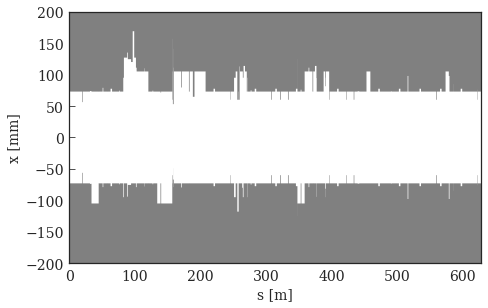

In [2]:
# Loading horizontal aperture
[sX, aperExtX, aperIntX] = myToolbox.plotPSaperture(section=[0], plane=0)
aperExtX *= 1e-3
aperIntX *= 1e-3

np.savetxt('model/aperture_X.txt',
           np.hstack((np.array(sX, ndmin=2).T, np.array(aperExtX, ndmin=2).T, np.array(aperIntX, ndmin=2).T)),
          header='Horizontal aperture\nPosition [m] - Aperture Ext [m] - Aperture Int [m]')

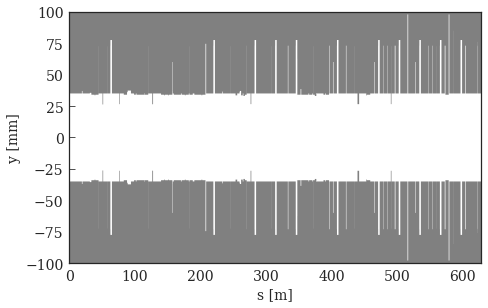

In [3]:
# Loading horizontal aperture
[sY, aperExtY, aperIntY] = myToolbox.plotPSaperture(section=[0], plane=1)
aperExtY *= 1e-3
aperIntY *= 1e-3

np.savetxt('model/aperture_Y.txt',
           np.hstack((np.array(sY, ndmin=2).T, np.array(aperExtY, ndmin=2).T, np.array(aperIntY, ndmin=2).T)),
          header='Vertical aperture\nPosition [m] - Aperture Ext [m] - Aperture Int [m]')

## Optics

In [4]:
# Optics selection
optics_ouptut_folder = './source/PS-optics/output/'
optics_case = 'PS_LHC_Extraction_NoExtractElem_customOutput.outx'

In [5]:
# Loading optics file

opticFile=metaclass.twiss(optics_ouptut_folder+optics_case)
    
name = opticFile.NAME
positionS = opticFile.S
length = opticFile.L
betaX = opticFile.BETX
betaY = opticFile.BETY
dispersionX = opticFile.DISP1
dispersionY = opticFile.DISP3

nElements_PS = len(name)

np.savetxt('model/optics.txt',
           np.hstack((np.array(positionS, ndmin=2).T,
                      np.array(length, ndmin=2).T,
                      np.array(betaX, ndmin=2).T,
                      np.array(betaY, ndmin=2).T,
                      np.array(dispersionX, ndmin=2).T,
                      np.array(dispersionY, ndmin=2).T)),
          header='Optics\n'+optics_case+'\nPosition [m] - Length [m] - Beta X [m] - Beta Y [m] - Dx - Dy')


Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


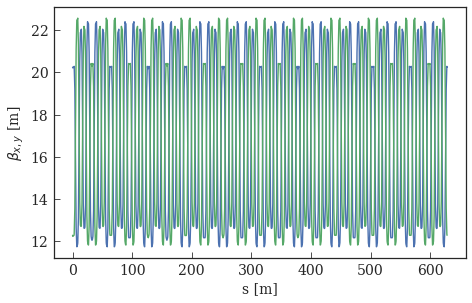

In [6]:
# Plotting optics

plt.figure('Beta functions')
plt.clf()
plt.plot(positionS, betaX)
plt.plot(positionS, betaY)
plt.xlabel('s [m]')
plt.ylabel('$\\beta_{x,y}$ [m]')
plt.show()

## Beam size

In [7]:
# Beam parameters input

# For BCMS beam at flat top before splittings
emittance_x_norm = 1.5e-6  # m rad
emittance_y_norm = 1.5e-6  # m rad
momentum_spread = 4.07e-4 # dp/p

In [8]:
# Loading PS ring parameters using BLonD input_parameters

from input_parameters.ring import Ring
from input_parameters.beam import Proton

ring_length = 2*np.pi*100
gamma_t = 6.1
alpha_0 = 1/gamma_t**2
momentum = 26e9
particle = Proton()

ps_ring_parameters = Ring(ring_length, alpha_0, momentum, particle)

In [9]:
# Calculating the beam size along the ring

beta_rel = ps_ring_parameters.beta[0,0]
gamma_rel = ps_ring_parameters.gamma[0,0]

sigma_x = np.sqrt(emittance_x_norm/(beta_rel*gamma_rel)*betaX + (dispersionX*momentum_spread)**2.)
sigma_y = np.sqrt(emittance_y_norm/(beta_rel*gamma_rel)*betaY + (dispersionY*momentum_spread)**2.)


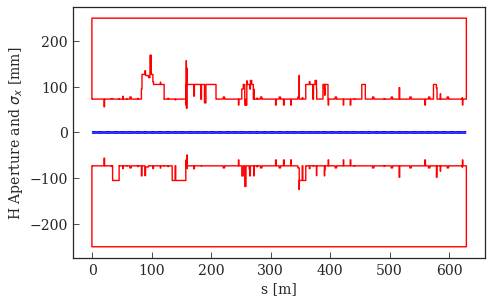

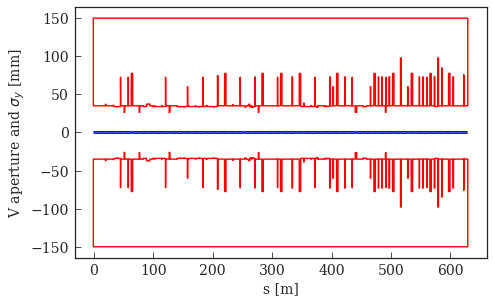

In [10]:
# Plotting the beam vs. aperture

plt.figure('Aperture and beam size H')
plt.clf()
plt.plot(sX, aperExtX*1e3, 'r')
plt.plot(sX, aperIntX*1e3, 'r')
plt.plot(positionS, sigma_x*1e3, 'b')
plt.plot(positionS, -sigma_x*1e3, 'b')
plt.xlabel('s [m]')
plt.ylabel('H Aperture and $\\sigma_x$ [mm]')

plt.figure('Aperture and beam size V')
plt.clf()
plt.plot(sY, aperExtY*1e3, 'r')
plt.plot(sY, aperIntY*1e3, 'r')
plt.plot(positionS, sigma_y*1e3, 'b')
plt.plot(positionS, -sigma_y*1e3, 'b')
plt.xlabel('s [m]')
plt.ylabel('V aperture and $\\sigma_y$ [mm]')
plt.show()

## Longitudinal space charge impedance

In [11]:
# Calculating the geometrical factor

semiSizeX = np.interp(positionS, sX[sX>=0], (aperExtX-aperIntX)[sX>=0]/2)
semiSizeY = np.interp(positionS, sY[sY>=0], (aperExtY-aperIntY)[sY>=0]/2)
sigma_XY = (sigma_x+sigma_y)/2

# Rectangular
geoFac = 1/4 + np.log(2*2*semiSizeY/(np.pi*np.sqrt(2)*sigma_XY)*np.tanh(np.pi*2*semiSizeX/(2*2*semiSizeY)))

# Circular
# geoFac = 1/4 + np.log((semiSizeX+semiSizeY)/2/(np.sqrt(2)*sigma_XY))

local_ImZ_over_n = - 1/(epsilon_0*c*beta_rel*gamma_rel**2.) * geoFac


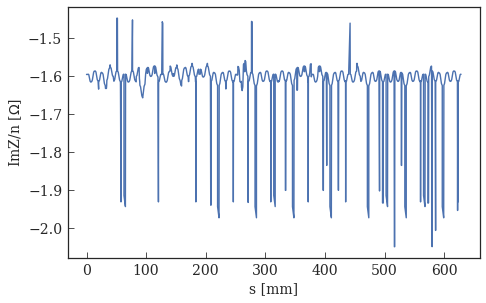

In [12]:
# Plotting local longitudinal space charge impedance

plt.figure('Local ImZ/n')
plt.clf()
plt.plot(positionS, local_ImZ_over_n)
plt.xlabel('s [mm]')
plt.ylabel('ImZ/n [$\\Omega$]')
plt.show()

In [13]:
# Integrated over one turn

final_ImZ_over_n = np.sum(local_ImZ_over_n*length)/np.sum(length)

print('Longitudinal space charge impedance at flat top: '+str(final_ImZ_over_n)+' Ohm')


Longitudinal space charge impedance at flat top: -1.62057612355 Ohm


## Along the ramp

In [14]:
# Loading B field and momentum program

loaded_field = np.load('./source/LHC_ramp_B.npz')
B_field = loaded_field['B_field']/1e4
time_array = loaded_field['time_B']*1e-3

bending_radius = 70.09  # [m]
momentum = B_field * bending_radius * c
momentum = momentum[time_array>170e-3]

time_array = time_array[time_array>170e-3]

ps_ring_parameters = Ring(ring_length, alpha_0, momentum, particle, n_turns = len(momentum)-1)

In [15]:
# Looping over the ramp, assuming the transverse emittance and momentum spread are constant (to be improved!)

# For BCMS beam at flat top before splittings
emittance_x_norm = 1.5e-6  # m rad
emittance_y_norm = 1.5e-6  # m rad
momentum_spread = 4.07e-4 # dp/p

final_ImZ_over_n = np.zeros(len(ps_ring_parameters.momentum[0]))

for index_momentum in range(len(ps_ring_parameters.momentum[0])):
    
    beta_rel = ps_ring_parameters.beta[0, index_momentum]
    gamma_rel = ps_ring_parameters.gamma[0, index_momentum]

    sigma_x = np.sqrt(emittance_x_norm/(beta_rel*gamma_rel)*betaX + (dispersionX*momentum_spread)**2.)
    sigma_y = np.sqrt(emittance_y_norm/(beta_rel*gamma_rel)*betaY + (dispersionY*momentum_spread)**2.)

    # Calculating the geometrical factor

    semiSizeX = np.interp(positionS, sX[sX>=0], (aperExtX-aperIntX)[sX>=0]/2)
    semiSizeY = np.interp(positionS, sY[sY>=0], (aperExtY-aperIntY)[sY>=0]/2)
    sigma_XY = (sigma_x+sigma_y)/2

    # Rectangular
    geoFac = 1/4 + np.log(2*2*semiSizeY/(np.pi*np.sqrt(2)*sigma_XY)*np.tanh(np.pi*2*semiSizeX/(2*2*semiSizeY)))

    # Circular
    # geoFac = 1/4 + np.log((semiSizeX+semiSizeY)/2/(np.sqrt(2)*sigma_XY))

    local_ImZ_over_n = - 1/(epsilon_0*c*beta_rel*gamma_rel**2.) * geoFac
    
    final_ImZ_over_n[index_momentum] = np.sum(local_ImZ_over_n*length)/np.sum(length)

Bottom: -151.045588125
Plateau: -73.4087581529
Top: -1.5794608974


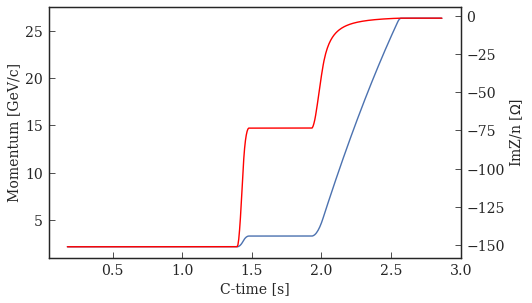

In [16]:
# Plotting the impedance along the ramp

print('Bottom: '+str(final_ImZ_over_n[0]))
print('Plateau: '+str(final_ImZ_over_n[time_array>1.7][0]))
print('Top: '+str(final_ImZ_over_n[-1]))

plt.figure('Impedance along the ramp')
plt.plot(time_array, ps_ring_parameters.momentum[0]/1e9)
plt.xlabel('C-time [s]')
plt.ylabel('Momentum [GeV/c]')
plt.twinx()
plt.plot(time_array, final_ImZ_over_n, 'r')
plt.ylabel('ImZ/n [$\\Omega$]')
plt.savefig('figures/im_z_over_n_along_ramp.png')
plt.show()